In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lazypredict.Supervised import LazyClassifier
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score

In [2]:
df_norm = pd.read_csv("ptbdb_normal.csv", header = None)
df_abnorm = pd.read_csv("ptbdb_abnormal.csv", header = None)

In [3]:
df = pd.concat([df_norm, df_abnorm], axis=0).reset_index(drop=True)

df = df.sample(frac=1, random_state=12).reset_index(drop=True)
df.shape

(14552, 188)

In [4]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]

In [72]:
fig_y = px.histogram(y, x=187, title="Class Distribution in y", 
                     text_auto=True, labels={"x": "Class Labels", "y": "Number of Samples"}, color = 187)

fig_y.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height=600
)

fig_y.show()

In [5]:
fig_pie = px.pie(y, names = 187, title="Percentage Label Distribution in y", hole=0.3)
fig_pie.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height = 900
)
fig_pie.show()

In [6]:
target_class_size = len(y[y == 0])

undersampler = RandomUnderSampler(sampling_strategy=target_class_size / len(y[y == 0]), random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

In [75]:
fig_y = px.histogram(y_under, x=187, title="Class Distribution in y", 
                     text_auto=True, labels={"x": "Class Labels", "y": "Number of Samples"}, color = 187)

fig_y.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height=600
)

fig_y.show()

In [76]:
fig_pie = px.pie(y_under, names = 187, title="Percentage Label Distribution in y", hole=0.3)
fig_pie.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height = 600
)
fig_pie.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42, stratify=y_under)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6473, 187), (1619, 187), (6473,), (1619,))

---

In [8]:
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

X_train = pd.DataFrame(X_train.drop(columns=to_drop))
X_test = pd.DataFrame(X_test.drop(columns=to_drop))

In [9]:
X_train.shape, X_test.shape

((6473, 70), (1619, 70))

---

In [88]:
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(tree_method="gpu_hist", use_label_encoder=False)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring="balanced_accuracy", #Since this data suffers from class imbalance
    n_iter=200,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state= 12
)

random_search_xgb.fit(X_train, y_train)

print("Best Parameters for XGBClassifier:", random_search_xgb.best_params_)
print("Best Accuracy Score:", random_search_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for XGBClassifier: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1}
Best Accuracy Score: 0.9188975232316293


In [10]:
xgb_clf = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=500,
    max_depth=9,
    learning_rate=0.1,
    tree_method="gpu_hist",  
    use_label_encoder=False
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

class_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       810
         1.0       0.94      0.90      0.92       809

    accuracy                           0.92      1619
   macro avg       0.92      0.92      0.92      1619
weighted avg       0.92      0.92      0.92      1619

Confusion Matrix:
 [[761  49]
 [ 79 730]]


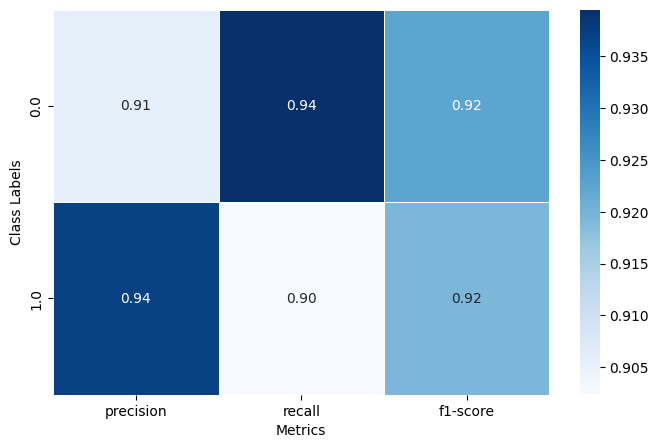

In [11]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).T.iloc[:-3, :-1] 

plt.figure(figsize=(8, 5))
sns.heatmap(df_report, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
# plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Class Labels")
plt.show()

Accuracy: 0.9209
Balanced Accuracy: 0.9209


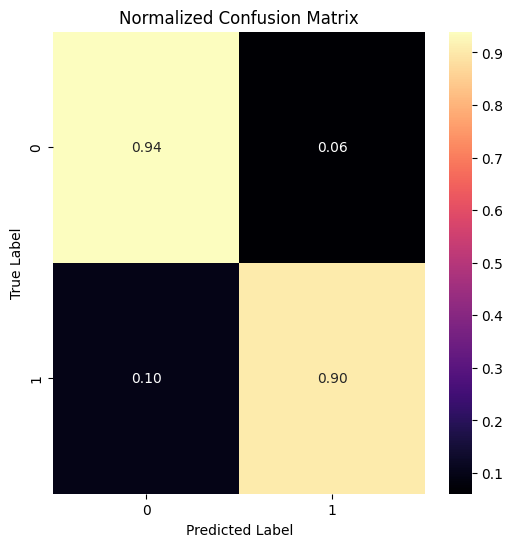

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

balanced_acc= balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="magma")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")

plt.show()